In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import librosa
import librosa.display
import soundfile as sf

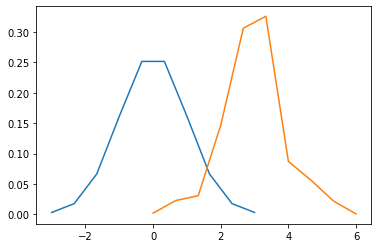

In [146]:
mu = 0
mu2 = 3
variance = 1
sigma = np.sqrt(variance)
x1 = np.linspace(mu - 3*sigma, mu + 3*sigma, 10)
x2 = np.linspace(mu2 - 3*sigma, mu2 + 3*sigma, 10)
y1 = stats.norm.pdf(x1, mu, sigma)
y2 = np.zeros(10)
y2[:5] = stats.norm.pdf(x2[:5], mu2, sigma) * np.cos(3*x2[5:]+0.5)
y2[5:] = stats.norm.pdf(x2[5:], mu2, sigma) * np.cos(3*x2[0:5])
y2 = np.abs(y2)
y1 = y1 / np.sum(y1)
y2 = y2 / np.sum(y2)
plt.plot(x1, y1)
plt.plot(x2, y2)
plt.show()

In [176]:
def gen_sinewave(freqs, total_time, sample_rate):
    """
    Generates sine waves
    """
    
    if type(freqs) == list:
        time_values = np.arange(0, total_time, 1 / sample_rate )
        signal = np.sin(2 *np.pi * freqs[0] * time_values)
        for f in freqs[1:]:
            signal = signal + np.sin(2 *np.pi * f * time_values)
        return signal
    elif type(freqs) == int:
        time_values = np.arange(0, total_time, 1 / sample_rate )
        return np.sin(2 *np.pi * freqs * time_values)
    else:
        print('unsuported type')
        return []

def optimal_1d_mapping(alpha, beta):
    """
    """
    # Sorts alpha and beta
    perm_a = np.argsort(alpha)
    perm_b = np.argsort(beta)

    map1 = alpha[perm_a]

    inv_p = np.zeros(len(perm_a))
    inv_p[perm_a] = np.arange(0, len(perm_a))

    sigma = perm_b[inv_p.astype(int)]
    return sigma

def compute_optimal_map(x, y):
    n = len(x)
    if len(x) != len(y):
        print('dimensions are not equal')
        return []
    
    pi = np.zeros((n, n))

    # Compute initial mass containers
    px = np.abs(x[0])
    py = np.abs(y[0])
    (i, j) = (0, 0)
    while True:
        # If there is less mass in container px, 
        # transfer as much as possible from py
        if (i >= n) and (j >= n):
            break
        if px < py:
            if (i < n ):
                pi[i, j] = py - px
                py = py - px
                i = i + 1
                if i >= n:
                    break
                # Refills x container with next mass
                px = x[i]
                
        else:
            if (j < n ):
                pi[i, j] = px - py
                px = px - py
                j = j + 1
                if j >= n:
                    break
                # Refills x container with next mass
                py = y[j]
                
    return pi

def interpolate(x, y, p, t):

    n = len(x)
    interp = np.zeros(n)
    for i in range(0, n):
        for j in range(0, n):
            k = int((1 - t) * i +  t *(j))
            interp[k] = interp[k] + p[i, j]
        #print(i)
    return interp


def plot_progression(y1, y2):
    ts = np.linspace(0, 1, 6)
    fig, ax = plt.subplots(6, 1)
    for t, i in zip(ts, range(0, 6)):
        ax[i].plot(t*y2 + (1-t) * y1)
        
def plot_spectogram(data, figsize=(8,6)):
    fig, ax = plt.subplots(figsize=figsize)
    S = np.abs(data)
    S_db = librosa.amplitude_to_db(S, ref=np.max)
    img = librosa.display.specshow(S_db,y_axis='log', x_axis='time', ax=ax, sr=44100)

    ax.set_title('Power spectrogram')

    fig.colorbar(img, ax=ax, format="%+2.0f dB")

def stft(wave):
    s = librosa.stft(wave, n_fft=1024, win_length=512, hop_length= int(512 / 2))
    S = np.abs(s)
    S_db = librosa.amplitude_to_db(S, ref=np.max)
    return s, S_db 

def join_stfts(s1, s2, n_windows):
    """
    """
    if (s1.shape[0] != s2.shape[0]):
        print("Different number of frequency bins")
    new_spec = np.empty((s1.shape[0], s1.shape[1] + s2.shape[1] + n_windows), dtype=complex)
    print(new_spec.shape, s1.shape, s2.shape)
    # Fills in spectrum from first clip
    new_spec[:, :s1.shape[1]] = s1[:, :]

    # Fills in spectrum from second clip
    new_spec[:, s1.shape[1] + n_windows :] = s2[:, :]

    alpha = s1[:, -1]
    beta = s2[:, 0]

    # Fills in interpolated spectrum
    ts = np.linspace(0, 1, n_windows)
    mass1 = np.sum(np.abs(alpha))
    mass2 = np.sum(np.abs(beta))

    
    sigma = optimal_1d_mapping(alpha, beta)
    beta2 = beta[sigma]
   
    p = compute_optimal_map(alpha, beta)
    

    #new_spec[:, s1.shape[1]] = new_spec[:, s1.shape[1]-1] / mass1
    #new_spec[:, s1.shape[1] + n_windows] = new_spec[:, s1.shape[1] + n_windows] / mass2
    print(mass1)
    print(mass2)

    for t, i in zip(ts, range(0, n_windows)):
        #new_spec[:, s1.shape[1] + i] = ((1-t) * alpha + t * beta ) 
        #print(t)
        new_spec[:, s1.shape[1] + i] = interpolate(alpha, beta, p, t)
    #for t, i in zip(ts, range(0, n_windows)):
        #new_spec[:, s1.shape[1] + i] = s1[:, -10]

    
    return new_spec

In [177]:
x1 = gen_sinewave(440, 4, 44100) * 0.2 
x2 = gen_sinewave(880, 4, 44100) * 0.2

s1, S_db1 = stft(x1)
s2, S_db2 = stft(x2)


(513, 910) (513, 140) (513, 670)
106.45302406651996
107.0437003714912
0.0


<ipython-input-176-1163a22e980d>:63: ComplexWarning: Casting complex values to real discards the imaginary part
  pi[i, j] = px - py
<ipython-input-176-1163a22e980d>:53: ComplexWarning: Casting complex values to real discards the imaginary part
  pi[i, j] = py - px


0.010101010101010102
0.020202020202020204
0.030303030303030304
0.04040404040404041
0.05050505050505051
0.06060606060606061
0.07070707070707072
0.08080808080808081
0.09090909090909091
0.10101010101010102
0.11111111111111112
0.12121212121212122
0.13131313131313133
0.14141414141414144
0.15151515151515152
0.16161616161616163
0.17171717171717174
0.18181818181818182
0.19191919191919193
0.20202020202020204
0.21212121212121213
0.22222222222222224
0.23232323232323235
0.24242424242424243
0.25252525252525254
0.26262626262626265
0.27272727272727276
0.2828282828282829
0.29292929292929293
0.30303030303030304
0.31313131313131315
0.32323232323232326
0.33333333333333337
0.3434343434343435
0.3535353535353536
0.36363636363636365
0.37373737373737376
0.38383838383838387
0.393939393939394
0.4040404040404041
0.4141414141414142
0.42424242424242425
0.43434343434343436
0.4444444444444445
0.4545454545454546
0.4646464646464647
0.4747474747474748
0.48484848484848486
0.494949494949495
0.5050505050505051
0.515151515

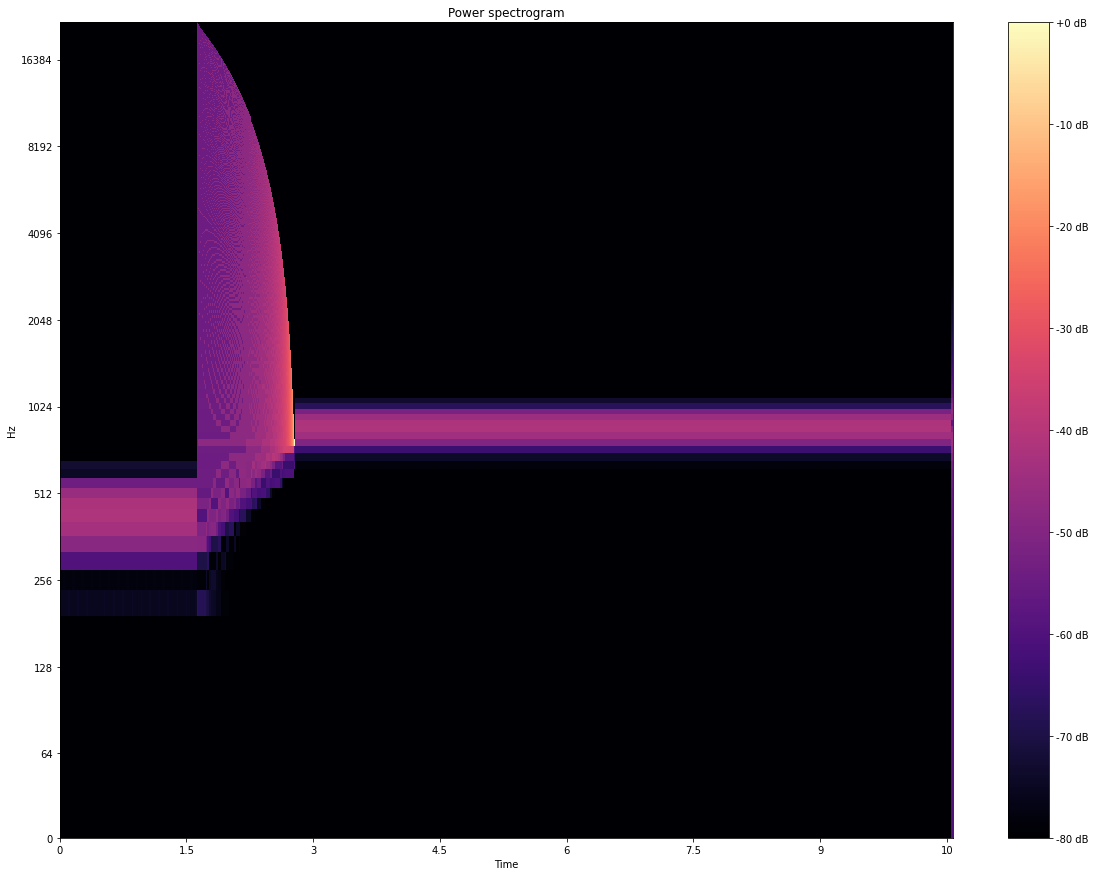

In [178]:
new_D = join_stfts(s1[:, :140], s2[:, 20:], 100)
plot_spectogram(new_D, figsize=(20,15))
#plt.axvline(3)

In [18]:

audio, sr = librosa.load("extract1.wav", sr=44100)
audio2, sr2 = librosa.load("extract2.wav", sr=44100)

ValueError: x and y must have same first dimension, but have shapes (40000,) and (0,)

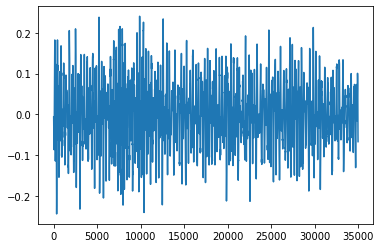

In [4]:
plt.plot(audio)
begin = 110000
end = 150000
extract = audio[begin:end]
plt.plot(np.arange(begin, end), extract)
sf.write('extract2.wav', extract, 44100)

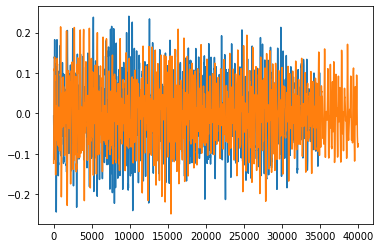

In [5]:
plt.plot(audio)
plt.plot(audio2)

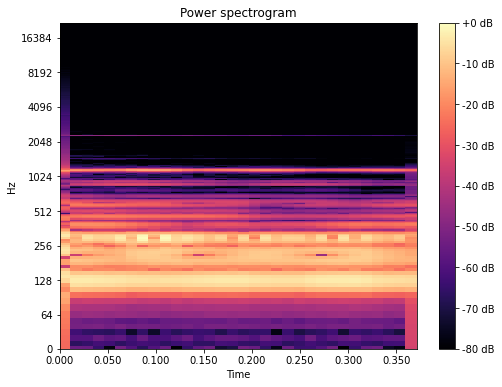

In [277]:
s1, S_db1 = stft(audio)
plot_spectogram(s1)

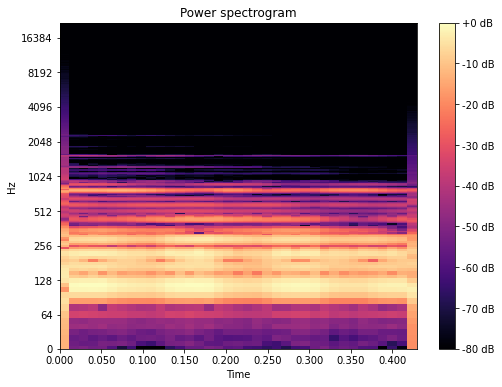

In [280]:
s2, S_db2 = stft(audio2)
plot_spectogram(s2)

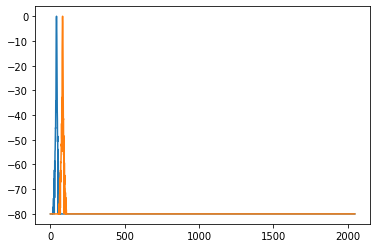

<Figure size 432x288 with 0 Axes>

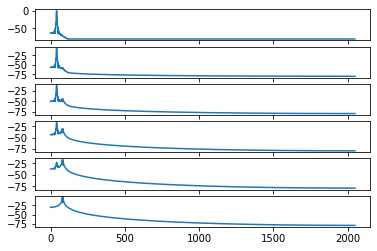

In [22]:
plt.plot(S_db1[:, -20])
plt.plot(S_db2[:, 20])
plt.figure()
plot_progression(S_db1[:, -1], S_db2[:, 0])

(1025, 228) (1025, 69)


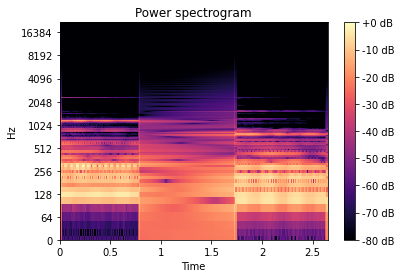

In [255]:
new_D = join_stfts(s1, s2, 80)
plot_spectogram(new_D[:])

/home/bernardotorres/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/bernardotorres/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/bernardotorres/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


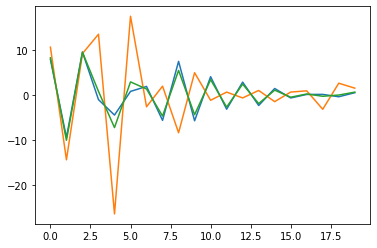

In [245]:
plt.plot(s1[:20, -1])
plt.plot(s2[:20, 0])
plt.plot(new_D[:20, s1.shape[1]+10])
#plt.plot(new_D[:20, s1.shape[1]+80])